**Intel natural scenes dataset classification using Transferlearning Resnet50**

MUHAMMAD SUFYAN ARSHAD
320416

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import numpy as np
from imutils import paths
import matplotlib.pyplot as plt
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

Setting up directory to load dataset

In [ ]:
train_dir = "/content/drive/MyDrive/intel-image-classification.zip (Unzipped Files)/seg_train/seg_train/"
test_dir = "/content/drive/MyDrive/intel-image-classification.zip (Unzipped Files)/Test_data.zip (Unzipped Files)/seg_pred/seg_pred"
valid_dir = "/content/drive/MyDrive/intel-image-classification.zip (Unzipped Files)/seg_test/seg_test/"

In [ ]:
# Create dataset batches for model with image augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=90, width_shift_range=0.2, height_shift_range=0.3, shear_range=0.2, zoom_range=0.2, horizontal_flip=True,)

val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(150, 150), 
        batch_size=64,
        seed=1)

validation_generator = val_datagen.flow_from_directory(
        valid_dir,
        shuffle=False,
        target_size=(150, 150),
        batch_size=64,
        seed=1)

pred_datagen = ImageDataGenerator()
prediction_generator = pred_datagen.flow_from_directory(
        test_dir,
        shuffle=False,
        target_size=(150, 150),
        batch_size=64,
        seed=1)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 7301 images belonging to 6 classes.


In [ ]:
#Resnet based model with weights from imagenet
model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [ ]:
# Adding Custom layers to the model
flat1 = Flatten()(model.layers[-1].output) # flatten last layer
class1 = Dense(1024, activation='relu')(flat1) # add FC layer on previous layer
output = Dense(6, activation='softmax')(class1) # add softmax layer

In [ ]:
# define the new model
model = Model(inputs=model.inputs, outputs=output)
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:

# Compiling SGD opt based model with learning rate=0.001 and momentum=0.9
from keras.optimizers import SGD
sgd = SGD(lr=0.001, decay=1e-7, momentum=.9)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

**Model Training**

In [ ]:
# Training the model
H = model.fit(
      train_generator,
      epochs=11,
      validation_data=validation_generator,
      verbose=1)

Epoch 1/11
220/220 [==============================] - 129s 564ms/step - loss: 0.9502 - accuracy: 0.7117 - val_loss: 0.4405 - val_accuracy: 0.8567
Epoch 2/11
220/220 [==============================] - 121s 548ms/step - loss: 0.3675 - accuracy: 0.8658 - val_loss: 0.2803 - val_accuracy: 0.8963
Epoch 3/11
220/220 [==============================] - 120s 547ms/step - loss: 0.3022 - accuracy: 0.8904 - val_loss: 0.2752 - val_accuracy: 0.9043
Epoch 4/11
220/220 [==============================] - 120s 545ms/step - loss: 0.2683 - accuracy: 0.9038 - val_loss: 0.2927 - val_accuracy: 0.8913
Epoch 5/11
220/220 [==============================] - 119s 540ms/step - loss: 0.2388 - accuracy: 0.9147 - val_loss: 0.2650 - val_accuracy: 0.9020
Epoch 6/11
220/220 [==============================] - 119s 538ms/step - loss: 0.2271 - accuracy: 0.9134 - val_loss: 0.2703 - val_accuracy: 0.9030
Epoch 7/11
220/220 [==============================] - 119s 541ms/step - loss: 0.2021 - accuracy: 0.9276 - val_loss: 0.2667 -

In [ ]:
# save the model's trained weights
mdlpthwgts = "/content/drive/MyDrive/"
model.save(mdlpthwgts + 'weights_of_mdlf111.h5')

NameError: ignored

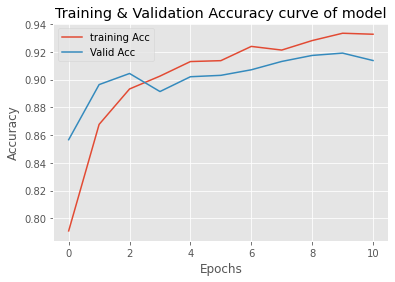

In [ ]:
'''Training Acc CURVE'''
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('Training & Validation Accuracy curve of model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['training Acc', 'Valid Acc'], loc='upper left')
plt.show()

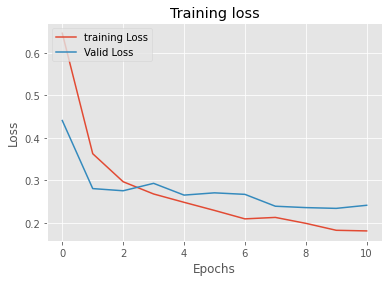

In [ ]:
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['training Loss', 'Valid Loss'], loc='upper left')
plt.show()

In [ ]:
# evaluate the model on a test dataset
results = model.evaluate(prediction_generator, batch_size=64, verbose=1)
print("test loss, test acc:", results)

115/115 [==============================] - 16s 138ms/step - loss: 0.5118 - accuracy: 0.8797
test loss, test acc: [0.5118090510368347, 0.8797425031661987]


**Confusion matrix Plot**

In [ ]:
prediction = model.predict(prediction_generator, batch_size=64, verbose=1)

115/115 [==============================] - 16s 135ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
pred = np.argmax(prediction, axis=1)
print(confusion_matrix(prediction_generator.classes, pred))

[[ 995    5    3    1   10  130]
 [   5 1148    4    3    3    3]
 [   2    7  995  271   51    4]
 [   4    6   74 1143   65    5]
 [  14    5   26   79  992   12]
 [  62    9    5    2    8 1150]]


**Classification** **Report**

In [ ]:
print('Classification Report:')
target_names = ['Buildings', 'Forest', 'Glacier', 'Mountain', 'Sea', 'Street']
print(classification_report(prediction_generator.classes, pred, target_names=target_names))

Classification Report:
              precision    recall  f1-score   support

   Buildings       0.92      0.87      0.89      1144
      Forest       0.97      0.98      0.98      1166
     Glacier       0.90      0.75      0.82      1330
    Mountain       0.76      0.88      0.82      1297
         Sea       0.88      0.88      0.88      1128
      Street       0.88      0.93      0.91      1236

    accuracy                           0.88      7301
   macro avg       0.89      0.88      0.88      7301
weighted avg       0.88      0.88      0.88      7301



**Heatmap of color encoded Confusion matrix**

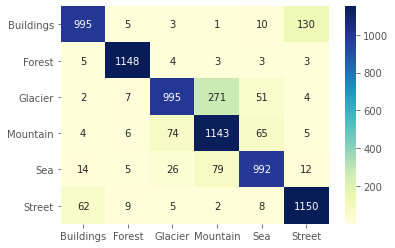

In [ ]:
confusion_mtx= confusion_matrix(prediction_generator.classes, pred)
import seaborn as sns
sns.heatmap(confusion_mtx, xticklabels=target_names, yticklabels=target_names,
            annot=True, fmt='d', cmap="YlGnBu")

In [ ]:
# Visual Results
vis_dir="/content/drive/MyDrive/New folder (3)/"
vis_datagen = ImageDataGenerator()
vis_generator = vis_datagen.flow_from_directory(
        vis_dir, 
        shuffle=False, 
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=1,
        seed=1)

visual = model.predict(vis_generator, batch_size=1, verbose=1)
vis = np.argmax(visual, axis=1)
print('Confusion Matrix:')
print(confusion_matrix(vis_generator.classes, vis))

Found 6 images belonging to 6 classes.
6/6 [==============================] - 0s 15ms/step
Confusion Matrix:
[[1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]]


In [ ]:
'''
Resnet50 model 

Rot range= 90
Width shift= 0.1
Height shift=0.1
Shear=0.1
Zoom=0.1
Test Acc  0.8876
----------------------------------------
Rot range= 90
Width shift= 0.1
Height shift=0.1
Shear=0.1
Zoom=0.1
Test acc 0.8893 sth
epoch 12
----------------------------------------
Rot range= 90
Width shift= 0.2
Height shift=0.3
Shear=0.1
Zoom=0.2
Test acc 0.8951
epoch 12
----------------------------------------
Resnet50 model taken from example.ipynb
iRot range= 90
Width shift= 0.2
Height shift=0.3
Shear=0.1
Zoom=0.2
Test acc 0.8642
epoch 25---best valid acc till 11th epoch
'''